<a href="https://colab.research.google.com/github/atopoxo/AI/blob/master/TestCase/%E5%9B%9E%E5%A3%B0%E4%BF%A1%E5%8F%B7(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

num_batches:
666


<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.7699229


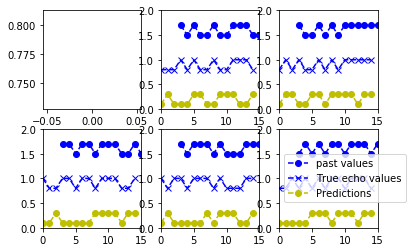

Step 100 Loss 0.5471881


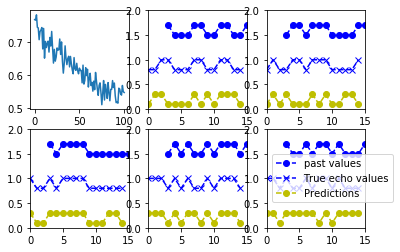

Step 200 Loss 0.4296803


KeyboardInterrupt: ignored

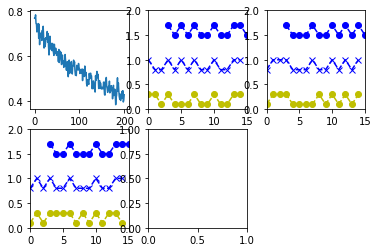

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 5
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length // batch_size // truncated_backprop_length
print("num_batches:")
print(num_batches)

def generateData():
  x = np.array(np.random.choice(2, total_series_length, p = [0.5, 0.5]))
  y = np.roll(x, echo_step)
  y[0 : echo_step] = 0
  
  x = x.reshape((batch_size, -1))
  y = y.reshape((batch_size, -1))
  
  return (x, y)

def plot(loss_list, predictions_series, batchX, batchY):
  plt.subplot(2, 3, 1)
  plt.cla()
  plt.plot(loss_list)
  
  for batch_series_idx in range(batch_size):
    one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
    single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])
    
    plt.subplot(2, 3, batch_series_idx + 2)
    plt.cla()
    plt.axis([0, truncated_backprop_length, 0, 2])
    
    left_offset = range(truncated_backprop_length)
    left_offset2 = range(echo_step, truncated_backprop_length + echo_step)
    
    label_1 = "past values"
    label_2 = "True echo values"
    label_3 = "Predictions"
    
    plt.plot(left_offset2, batchX[batch_series_idx, :] * 0.2 + 1.5, "o--b", label = label_1)
    plt.plot(left_offset, batchY[batch_series_idx, :] * 0.2 + 0.8, "x--b", label = label_2)
    plt.plot(left_offset, single_output_series * 0.2 + 0.1, "o--y", label = label_3)
    
  plt.legend(loc = 'best')
  plt.draw()
  plt.pause(0.0001)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

inputs_series = tf.unstack(batchX_placeholder, axis = 1)
labels_series = tf.unstack(batchY_placeholder, axis = 1)

current_state = init_state
predictions_series = []
losses = []

for current_input, labels in zip(inputs_series, labels_series):
  current_input = tf.reshape(current_input, [batch_size, 1])
  input_and_state_concatenated = tf.concat([current_input, current_state], 1)
  
  current_state = tf.contrib.layers.fully_connected(input_and_state_concatenated, state_size, activation_fn = tf.tanh)
  logits = tf.contrib.layers.fully_connected(current_state, num_classes, activation_fn = None)
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, logits = logits)
  losses.append(loss)
  predictions = tf.nn.softmax(logits)
  predictions_series.append(predictions)
  
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  plt.ion()
  plt.figure()
  plt.show()
  loss_list = []
  
  for epoch_idx in range(num_epochs):
    x, y = generateData()
    _current_state = np.zeros((batch_size, state_size))
    
    print("New data, epoch", epoch_idx)
    for batch_idx in range(num_batches):
      start_idx = batch_idx * truncated_backprop_length
      end_idx = start_idx + truncated_backprop_length
      batchX = x[:, start_idx : end_idx]
      batchY = y[:, start_idx : end_idx]
      
      _total_loss, _train_step, _current_state, _predictions_series = sess.run(
        [total_loss, train_step, current_state, predictions_series],
        feed_dict = {
            batchX_placeholder : batchX,
            batchY_placeholder : batchY,
            init_state : _current_state
        })
      loss_list.append(_total_loss)
      
      if batch_idx % 100 == 0:
        print("Step", batch_idx, "Loss", _total_loss)
        plot(loss_list, _predictions_series, batchX, batchY)
        
  plt.ioff()
  plt.show()